<a href="https://colab.research.google.com/github/Tidnom/cardio-vascular-disease-predictor/blob/main/Heartdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving heart_latest.csv to heart_latest.csv


In [ ]:
df=pd.read_csv('heart_latest.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,60,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,35,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,55,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,56,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
print("DataFrame shape:", df.shape)

DataFrame shape: (289, 14)


In [ ]:
cont_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

outlier_indices = []
for col in cont_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_indices.extend(outliers.index.tolist())
    print(f"Feature '{col}': found {len(outliers)} outliers")

outlier_indices = list(set(outlier_indices))

Feature 'age': found 0 outliers
Feature 'trtbps': found 9 outliers
Feature 'chol': found 5 outliers
Feature 'thalachh': found 1 outliers
Feature 'oldpeak': found 4 outliers


In [ ]:
df_no_outliers = df.drop(index=outlier_indices).copy()

print(f"Removed {len(outlier_indices)} rows containing outliers.")
print(f"Final dataset shape: {df_no_outliers.shape}")


Removed 18 rows containing outliers.
Final dataset shape: (271, 14)


In [ ]:
print(df_no_outliers.describe())

              age         sex          cp      trtbps        chol         fbs  \
count  271.000000  271.000000  271.000000  271.000000  271.000000  271.000000   
mean    53.608856    0.693727    1.044280  129.501845  243.952030    0.136531   
std      9.188668    0.461797    1.024638   15.186952   44.377771    0.343987   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     46.000000    0.000000    0.000000  120.000000  211.500000    0.000000   
50%     54.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     60.000000    1.000000    2.000000  140.000000  273.000000    0.000000   
max     77.000000    1.000000    3.000000  170.000000  360.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  271.000000  271.000000  271.000000  271.000000  271.000000  271.000000   
mean     0.516605  150.649446    0.306273    0.922509    1.446494    0.697417   
std      0.507993   22.6306

In [ ]:
# Age bins
df_no_outliers['age_cat'] = pd.cut(
    df_no_outliers['age'],
    bins=[0, 45, 55, 65, 100],
    labels=[0, 1, 2, 3]  # directly assign numeric labels
)


In [ ]:
# trestbps bins
df_no_outliers['trtbps_cat'] = pd.cut(
    df_no_outliers['trtbps'],
    bins=[0, 120, 140, df_no_outliers['trtbps'].max()],
    labels=[0, 1, 2]
)

In [ ]:
# chol bins
df_no_outliers['chol_cat'] = pd.cut(
    df_no_outliers['chol'],
    bins=[0, 200, 240, df_no_outliers['chol'].max()],
    labels=[0, 1, 2]
)

In [ ]:
# thalach bins
df_no_outliers['thalachh_cat'] = pd.cut(
    df_no_outliers['thalachh'],
    bins=[0, 120, 150, df_no_outliers['thalachh'].max()],
    labels=[0, 1, 2]
)

In [ ]:
# oldpeak bins
q1, q2, q3 = df_no_outliers['oldpeak'].quantile([0.25, 0.5, 0.75])
df_no_outliers['oldpeak_cat'] = pd.cut(
    df_no_outliers['oldpeak'],
    bins=[-0.01, q1, q2, q3, df_no_outliers['oldpeak'].max()],
    labels=[0, 1, 2, 3]
)

In [ ]:
print(df_no_outliers.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   60    1   3     145   233    1        0       150     0      2.3    0   
1   35    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   55    1   1     120   236    0        1       178     0      0.8    2   
4   56    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output age_cat trtbps_cat thalachh_cat chol_cat oldpeak_cat  
0    0      1       1       2          2            1        1           3  
1    0      2       1       0          1            2        2           3  
2    0      2       1       0          1            2        1           2  
3    0      2       1       1          0            2        1           2  
4    0      2       1       2          0            2        2           1  


In [ ]:
cols_to_drop = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

df_no_outliers.drop(columns=cols_to_drop, inplace=True)

print(df_no_outliers.head())

   sex  cp  fbs  restecg  exng  slp  caa  thall  output age_cat trtbps_cat  \
0    1   3    1        0     0    0    0      1       1       2          2   
1    1   2    0        1     0    0    0      2       1       0          1   
2    0   1    0        0     0    2    0      2       1       0          1   
3    1   1    0        1     0    2    0      2       1       1          0   
4    0   0    0        1     1    2    0      2       1       2          0   

  thalachh_cat chol_cat oldpeak_cat  
0            1        1           3  
1            2        2           3  
2            2        1           2  
3            2        1           2  
4            2        2           1  


In [ ]:
pip install kmodes

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
male_df = df_no_outliers[df_no_outliers["sex"] == 1].copy()
female_df = df_no_outliers[df_no_outliers["sex"] == 0].copy()

In [ ]:
def plot_kmodes_elbow(df, max_k=5, title="Elbow Method"):
    cost = []
    K = range(1, max_k + 1)
    for k in K:
        km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
        km.fit_predict(df)
        cost.append(km.cost_)
    plt.figure(figsize=(6, 4))
    plt.plot(K, cost, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')
    plt.title(title)
    plt.show()


🔹 Elbow curve for Male dataset:


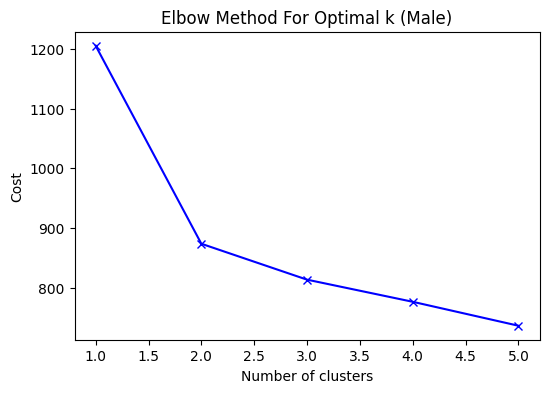


🔹 Elbow curve for Female dataset:


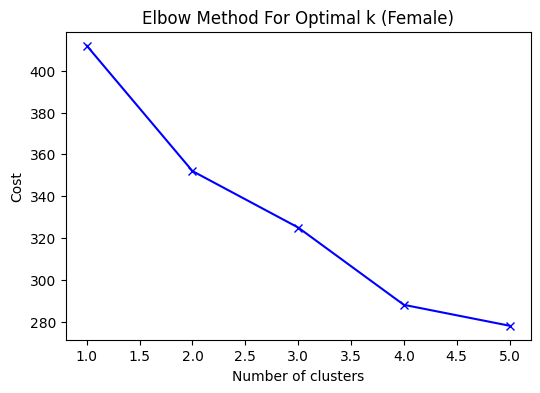

In [ ]:
print("\n🔹 Elbow curve for Male dataset:")
plot_kmodes_elbow(
    male_df.drop(columns=["sex"]),
    max_k=5,
    title="Elbow Method For Optimal k (Male)"
)

print("\n🔹 Elbow curve for Female dataset:")
plot_kmodes_elbow(
    female_df.drop(columns=["sex"]),
    max_k=5,
    title="Elbow Method For Optimal k (Female)"
)

In [ ]:
km_male = KModes(n_clusters=2, init='Huang', n_init=5, verbose=0)
male_clusters = km_male.fit_predict(male_df.drop(columns=["sex"]))
male_df["Cluster"] = male_clusters

km_female = KModes(n_clusters=4, init='Huang', n_init=5, verbose=0)
female_clusters = km_female.fit_predict(female_df.drop(columns=["sex"]))
female_df["Cluster"] = female_clusters

In [ ]:
print("Male cluster sizes:\n", male_df["Cluster"].value_counts().sort_index())
print("\nFemale cluster sizes:\n", female_df["Cluster"].value_counts().sort_index())


Male cluster sizes:
 Cluster
0    107
1     81
Name: count, dtype: int64

Female cluster sizes:
 Cluster
0    17
1    27
2    16
3    23
Name: count, dtype: int64


In [ ]:
for c in sorted(male_df["Cluster"].unique()):
    print(f"\n=== Male Cluster {c} profile ===")
    display(male_df[male_df["Cluster"] == c].describe(include='all'))



=== Male Cluster 0 profile ===


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,thalachh_cat,chol_cat,oldpeak_cat,Cluster
count,107.0,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.0,107.0,107.0,107.0,107.0,107.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,53.0,84.0,51.0,53.0,NaN
mean,1.0,1.336449,0.158879,0.616822,0.121495,1.663551,0.485981,2.224299,0.803738,NaN,NaN,NaN,NaN,NaN,0.0
std,0.0,0.970741,0.367283,0.488449,0.328239,0.597857,1.012791,0.571466,0.399038,NaN,NaN,NaN,NaN,NaN,0.0
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
25%,1.0,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0
50%,1.0,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0
75%,1.0,2.000000,0.000000,1.000000,0.000000,2.000000,0.500000,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0



=== Male Cluster 1 profile ===


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,thalachh_cat,chol_cat,oldpeak_cat,Cluster
count,81.0,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0,81.0,81.0,81.0,81.0,81.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,2.0,3.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,37.0,43.0,49.0,41.0,NaN
mean,1.0,0.506173,0.135802,0.345679,0.679012,1.086420,1.135802,2.592593,0.061728,NaN,NaN,NaN,NaN,NaN,1.0
std,0.0,0.950309,0.344713,0.478552,0.469765,0.452701,0.958555,0.685160,0.242161,NaN,NaN,NaN,NaN,NaN,0.0
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
25%,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
50%,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
75%,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
for c in sorted(female_df["Cluster"].unique()):
    print(f"\n=== Female Cluster {c} profile ===")
    display(female_df[female_df["Cluster"] == c].describe(include='all'))



=== Female Cluster 0 profile ===


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,thalachh_cat,chol_cat,oldpeak_cat,Cluster
count,17.0,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.0,17.0,17.0,17.0,17.0,17.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,3.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,1.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,10.0,12.0,10.0,NaN
mean,0.0,1.588235,0.058824,0.352941,0.176471,1.529412,0.235294,1.941176,1.0,NaN,NaN,NaN,NaN,NaN,0.0
std,0.0,0.795206,0.242536,0.606339,0.392953,0.624264,0.437237,0.555719,0.0,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,0.0
25%,0.0,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.0,NaN,NaN,NaN,NaN,NaN,0.0
50%,0.0,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.0,NaN,NaN,NaN,NaN,NaN,0.0
75%,0.0,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.0,NaN,NaN,NaN,NaN,NaN,0.0



=== Female Cluster 1 profile ===


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,thalachh_cat,chol_cat,oldpeak_cat,Cluster
count,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,1.0,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,18.0,21.0,15.0,14.0,NaN
mean,0.0,1.592593,0.037037,0.925926,0.074074,1.592593,0.296296,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
std,0.0,0.930643,0.192450,0.266880,0.266880,0.572394,0.608581,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
25%,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
50%,0.0,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
75%,0.0,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0



=== Female Cluster 2 profile ===


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,thalachh_cat,chol_cat,oldpeak_cat,Cluster
count,16.0,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.0,16.0,16.0,16.0,16.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,4.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,2.0,3.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,9.0,7.0,14.0,7.0,NaN
mean,0.0,0.375000,0.187500,0.437500,0.437500,1.062500,1.312500,2.500000,0.187500,NaN,NaN,NaN,NaN,NaN,2.0
std,0.0,0.885061,0.403113,0.512348,0.512348,0.442531,1.352467,0.516398,0.403113,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2.0
25%,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2.0
50%,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,2.500000,0.000000,NaN,NaN,NaN,NaN,NaN,2.0
75%,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2.0



=== Female Cluster 3 profile ===


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,thalachh_cat,chol_cat,oldpeak_cat,Cluster
count,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.000000,23.0,23.0,23.0,23.0,23.0,23.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,1.0,3.0,3.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,17.0,23.0,19.0,15.0,NaN
mean,0.0,1.000000,0.173913,0.347826,0.130435,1.739130,0.521739,2.0,0.913043,NaN,NaN,NaN,NaN,NaN,3.0
std,0.0,0.797724,0.387553,0.486985,0.344350,0.448978,0.897956,0.0,0.288104,NaN,NaN,NaN,NaN,NaN,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0,0.000000,NaN,NaN,NaN,NaN,NaN,3.0
25%,0.0,0.500000,0.000000,0.000000,0.000000,1.500000,0.000000,2.0,1.000000,NaN,NaN,NaN,NaN,NaN,3.0
50%,0.0,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.0,1.000000,NaN,NaN,NaN,NaN,NaN,3.0
75%,0.0,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.0,1.000000,NaN,NaN,NaN,NaN,NaN,3.0


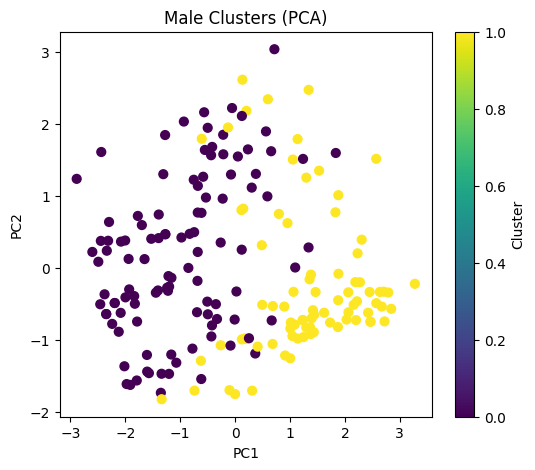

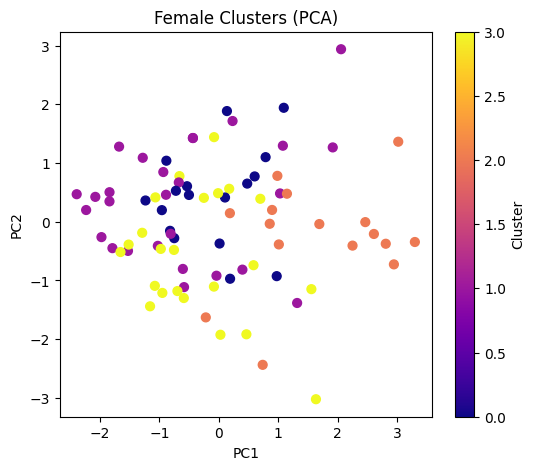

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Male plot
pca = PCA(n_components=2)
male_pca = pca.fit_transform(male_df.drop(columns=["Cluster", "sex"]))
plt.figure(figsize=(6, 5))
plt.scatter(male_pca[:,0], male_pca[:,1], c=male_df["Cluster"], cmap="viridis", s=40)
plt.title("Male Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Female plot
pca = PCA(n_components=2)
female_pca = pca.fit_transform(female_df.drop(columns=["Cluster", "sex"]))
plt.figure(figsize=(6, 5))
plt.scatter(female_pca[:,0], female_pca[:,1], c=female_df["Cluster"], cmap="plasma", s=40)
plt.title("Female Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
print("\nMale cluster condition rates:")
print(male_df.groupby("Cluster")["output"].mean())

print("\nFemale cluster condition rates:")
print(female_df.groupby("Cluster")["output"].mean())


Male cluster condition rates:
Cluster
0    0.803738
1    0.061728
Name: output, dtype: float64

Female cluster condition rates:
Cluster
0    1.000000
1    1.000000
2    0.187500
3    0.913043
Name: output, dtype: float64


In [ ]:
binned_cols = ['age_cat', 'trtbps_cat', 'chol_cat', 'thalachh_cat', 'oldpeak_cat']

for col in binned_cols:
    df_no_outliers[col] = df_no_outliers[col].astype(int)

Number of numeric features: 14


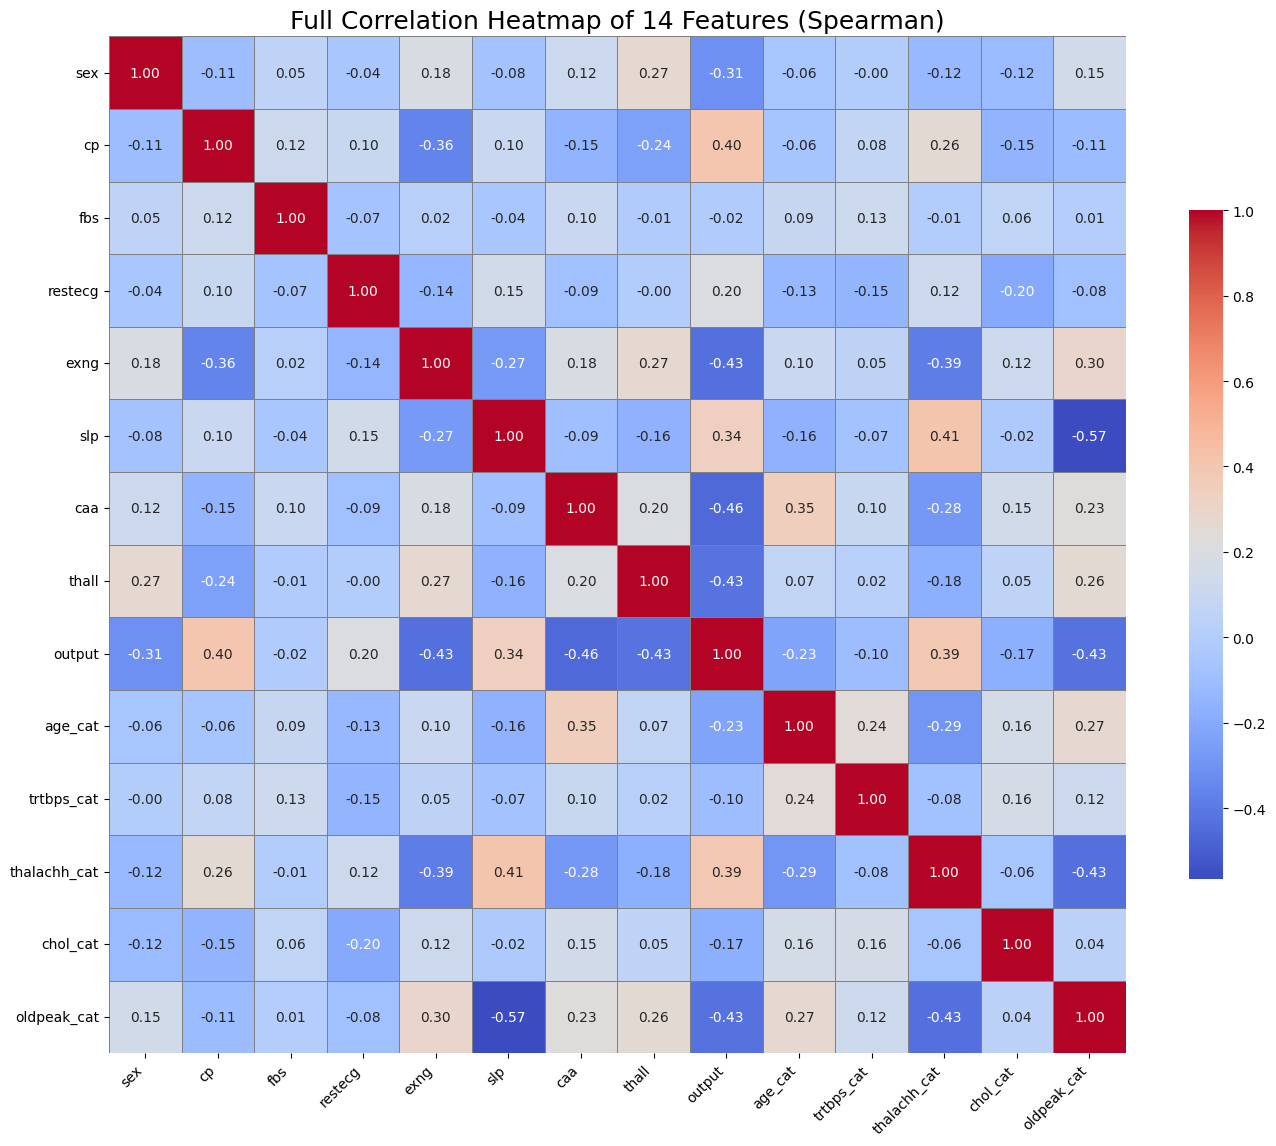

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_numeric = df_no_outliers.select_dtypes(include='number')

print(f"Number of numeric features: {df_numeric.shape[1]}")

corr_matrix = df_numeric.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={'shrink': 0.6},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Full Correlation Heatmap of 14 Features (Spearman)", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
X = combined_df.drop(columns=["output", "Cluster"])

y = combined_df["output"]

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_no_outliers.drop(columns='output'),
    df_no_outliers['output'],
    stratify=df_no_outliers['output'],
    test_size=0.2,
    random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {y_train_smote.value_counts().to_dict()}")


Before SMOTE: {1: 127, 0: 89}
After SMOTE: {1: 127, 0: 127}


In [ ]:
if 'Cluster' in df_no_outliers.columns:
    df_final = df_no_outliers.drop(columns=['Cluster'])
else:
    df_final = df_no_outliers.copy()
X = df_final.drop(columns=['output'])
y = df_final['output']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Features (X) shape: (271, 13)
Target (y) shape: (271,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (216, 13) (216,)
Test set shape: (55, 13) (55,)


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_enc, y_train)
dtree_preds = dtree.predict(X_test_enc)
evaluate_model(y_test, dtree_preds, "Decision Tree")



📊 Decision Tree Results:
Accuracy:  0.7818
Precision: 0.7827
Recall:    0.7818
F1-score:  0.7778


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500, max_depth=4, random_state=42
)
rf.fit(X_train_enc, y_train)
rf_preds = rf.predict(X_test_enc)
evaluate_model(y_test, rf_preds, "Random Forest")


📊 Random Forest Results:
Accuracy:  0.8364
Precision: 0.8545
Recall:    0.8364
F1-score:  0.8297


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)


mlp = MLPClassifier(
    hidden_layer_sizes=(50, 30), max_iter=300, random_state=42
)
mlp.fit(X_train_imputed, y_train)
mlp_preds = mlp.predict(X_test_imputed)
evaluate_model(y_test, mlp_preds, "Multilayer Perceptron")


📊 Multilayer Perceptron Results:
Accuracy:  0.7273
Precision: 0.7292
Recall:    0.7273
F1-score:  0.7280


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train_enc, y_train)
xgb_preds = xgb.predict(X_test_enc)
evaluate_model(y_test, xgb_preds, "XGBoost")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:52:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 XGBoost Results:
Accuracy:  0.8909
Precision: 0.8972
Recall:    0.8909
F1-score:  0.8889


In [ ]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)

svm = SVC(probability=True, random_state=42)
svm.fit(X_train_imputed, y_train)
svm_preds = svm.predict(X_test_imputed)
svm_probs = svm.predict_proba(X_test_imputed)[:, 1]

evaluate_model(y_test, svm_preds, "SVM")



📊 SVM Results:
Accuracy:  0.8364
Precision: 0.8545
Recall:    0.8364
F1-score:  0.8297


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)

logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_imputed, y_train)
logreg_preds = logreg.predict(X_test_imputed)
logreg_probs = logreg.predict_proba(X_test_imputed)[:, 1]

evaluate_model(y_test, logreg_preds, "Logistic Regression")


📊 Logistic Regression Results:
Accuracy:  0.7818
Precision: 0.7806
Recall:    0.7818
F1-score:  0.7802


In [ ]:
importances = rf.feature_importances_
feature_names = X.columns

for name, importance in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {importance:.4f}")

caa: 0.1733
thall: 0.1599
exng: 0.1346
oldpeak_cat: 0.1254
cp: 0.1118
thalachh_cat: 0.0707
slp: 0.0680
age_cat: 0.0423
restecg: 0.0340
sex: 0.0311
chol_cat: 0.0204
trtbps_cat: 0.0189
fbs: 0.0097


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')


In [ ]:
from sklearn.metrics import classification_report

def detailed_report(y_true, y_pred, model_name):
    print(f"\n📑 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=["No Cardio", "Cardio"]))


In [ ]:
dtree_probs = dtree.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, dtree_preds, "Decision Tree")



📑 Classification Report for Decision Tree:
              precision    recall  f1-score   support

   No Cardio       0.79      0.65      0.71        23
      Cardio       0.78      0.88      0.82        32

    accuracy                           0.78        55
   macro avg       0.78      0.76      0.77        55
weighted avg       0.78      0.78      0.78        55



In [ ]:
svm_probs = svm.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, svm_preds, "SVM")


📑 Classification Report for SVM:
              precision    recall  f1-score   support

   No Cardio       0.94      0.65      0.77        23
      Cardio       0.79      0.97      0.87        32

    accuracy                           0.84        55
   macro avg       0.87      0.81      0.82        55
weighted avg       0.85      0.84      0.83        55



In [ ]:
logreg_probs = logreg.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, logreg_preds, "Logistic Regression")


📑 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   No Cardio       0.76      0.70      0.73        23
      Cardio       0.79      0.84      0.82        32

    accuracy                           0.78        55
   macro avg       0.78      0.77      0.77        55
weighted avg       0.78      0.78      0.78        55



In [ ]:
rf_probs = rf.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, rf_preds, "Random Forest")



📑 Classification Report for Random Forest:
              precision    recall  f1-score   support

   No Cardio       0.94      0.65      0.77        23
      Cardio       0.79      0.97      0.87        32

    accuracy                           0.84        55
   macro avg       0.87      0.81      0.82        55
weighted avg       0.85      0.84      0.83        55



In [ ]:
mlp_probs = mlp.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, mlp_preds, "Multilayer Perceptron")



📑 Classification Report for Multilayer Perceptron:
              precision    recall  f1-score   support

   No Cardio       0.67      0.70      0.68        23
      Cardio       0.77      0.75      0.76        32

    accuracy                           0.73        55
   macro avg       0.72      0.72      0.72        55
weighted avg       0.73      0.73      0.73        55



In [ ]:
xgb_probs = xgb.predict_proba(X_test_enc)[:, 1]
detailed_report(y_test, xgb_preds, "XGBoost")



📑 Classification Report for XGBoost:
              precision    recall  f1-score   support

   No Cardio       0.95      0.78      0.86        23
      Cardio       0.86      0.97      0.91        32

    accuracy                           0.89        55
   macro avg       0.90      0.88      0.88        55
weighted avg       0.90      0.89      0.89        55



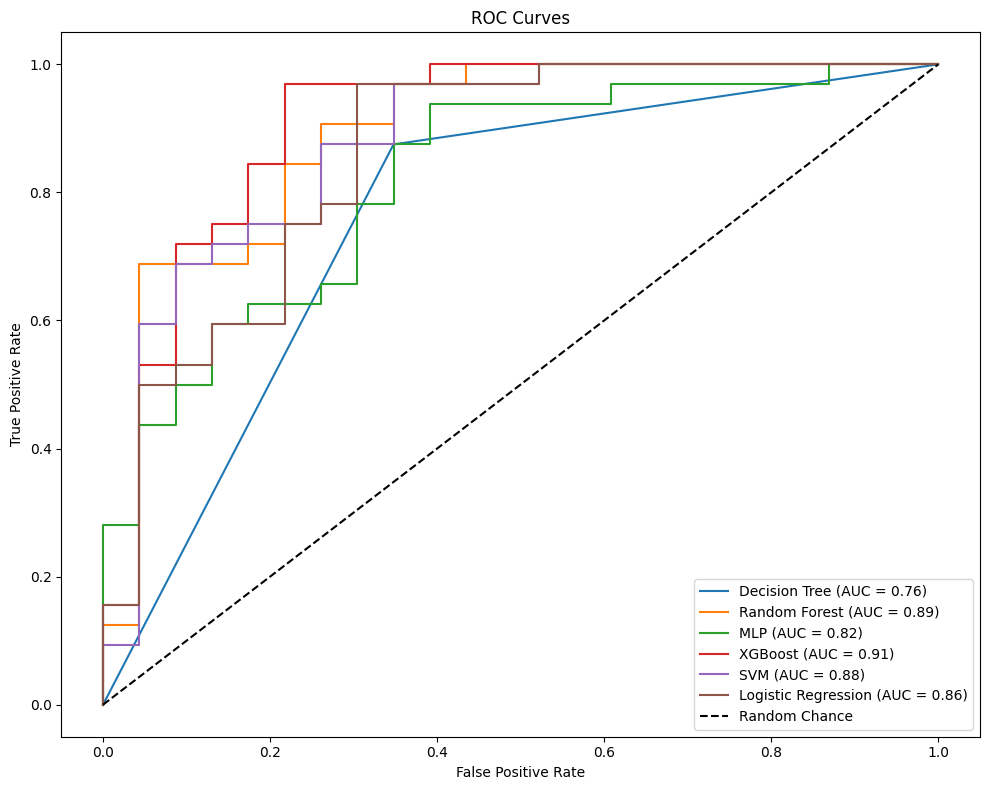

In [ ]:
plt.figure(figsize=(10, 8))

# models
plot_roc_curve(y_test, dtree_probs, "Decision Tree")
plot_roc_curve(y_test, rf_probs, "Random Forest")
plot_roc_curve(y_test, mlp_probs, "MLP")
plot_roc_curve(y_test, xgb_probs, "XGBoost")
plot_roc_curve(y_test, svm_probs, "SVM")
plot_roc_curve(y_test, logreg_probs, "Logistic Regression")

# reference line
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
dtree_params = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"],
}

dtree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dtree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
dtree_grid.fit(X_train_enc, y_train)

print("✅ Best Decision Tree Params:", dtree_grid.best_params_)
dtree_best = dtree_grid.best_estimator_
evaluate_model(y_test, dtree_best.predict(X_test_enc), "Tuned Decision Tree")


✅ Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

📊 Tuned Decision Tree Results:
Accuracy:  0.7636
Precision: 0.7655
Recall:    0.7636
F1-score:  0.7578


In [ ]:
rf_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [4, 6, 8],
    "min_samples_split": [2, 5],
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
rf_grid.fit(X_train_enc, y_train)

print("✅ Best Random Forest Params:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
evaluate_model(y_test, rf_best.predict(X_test_enc), "Tuned Random Forest")


✅ Best Random Forest Params: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}

📊 Tuned Random Forest Results:
Accuracy:  0.8364
Precision: 0.8545
Recall:    0.8364
F1-score:  0.8297


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

mlp_params = {
    "hidden_layer_sizes": [(50,), (50, 30), (100,)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001],
}

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)

mlp_grid = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42),
    mlp_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
mlp_grid.fit(X_train_imputed, y_train)

print("✅ Best MLP Params:", mlp_grid.best_params_)
mlp_best = mlp_grid.best_estimator_

X_test_imputed = imputer.transform(X_test_enc)
evaluate_model(y_test, mlp_best.predict(X_test_imputed), "Tuned MLP")

✅ Best MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}

📊 Tuned MLP Results:
Accuracy:  0.7818
Precision: 0.7806
Recall:    0.7818
F1-score:  0.7802


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 6],
    "n_estimators": [100, 300],
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    xgb_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
xgb_grid.fit(X_train_enc, y_train)

print("✅ Best XGBoost Params:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_
evaluate_model(y_test, xgb_best.predict(X_test_enc), "Tuned XGBoost")


✅ Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}

📊 Tuned XGBoost Results:
Accuracy:  0.8727
Precision: 0.8751
Recall:    0.8727
F1-score:  0.8711


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:59:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

logreg_params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],
}

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)

logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42),
    logreg_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
logreg_grid.fit(X_train_imputed, y_train)

print("✅ Best Logistic Regression Params:", logreg_grid.best_params_)
logreg_best = logreg_grid.best_estimator_

X_test_imputed = imputer.transform(X_test_enc)
evaluate_model(y_test, logreg_best.predict(X_test_imputed), "Tuned Logistic Regression")

✅ Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

📊 Tuned Logistic Regression Results:
Accuracy:  0.8364
Precision: 0.8545
Recall:    0.8364
F1-score:  0.8297


In [ ]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

svm_params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
}

imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_test_imputed = imputer.transform(X_test_enc)

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_params,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)
svm_grid.fit(X_train_imputed, y_train)

print("✅ Best SVM Params:", svm_grid.best_params_)
svm_best = svm_grid.best_estimator_

evaluate_model(y_test, svm_best.predict(X_test_imputed), "Tuned SVM")

✅ Best SVM Params: {'C': 0.1, 'kernel': 'linear'}

📊 Tuned SVM Results:
Accuracy:  0.8182
Precision: 0.8283
Recall:    0.8182
F1-score:  0.8123


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dtree_probs = dtree_best.predict_proba(X_test_enc)[:, 1]
rf_probs = rf_best.predict_proba(X_test_enc)[:, 1]
mlp_probs = mlp_best.predict_proba(X_test_enc)[:, 1]
xgb_probs = xgb_best.predict_proba(X_test_enc)[:, 1]
svm_probs = svm_best.predict_proba(X_test_enc)[:,1]
logreg_probs = logreg_best.predict_proba(X_test_enc)[:, 1]


In [ ]:
def plot_model_roc(y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")


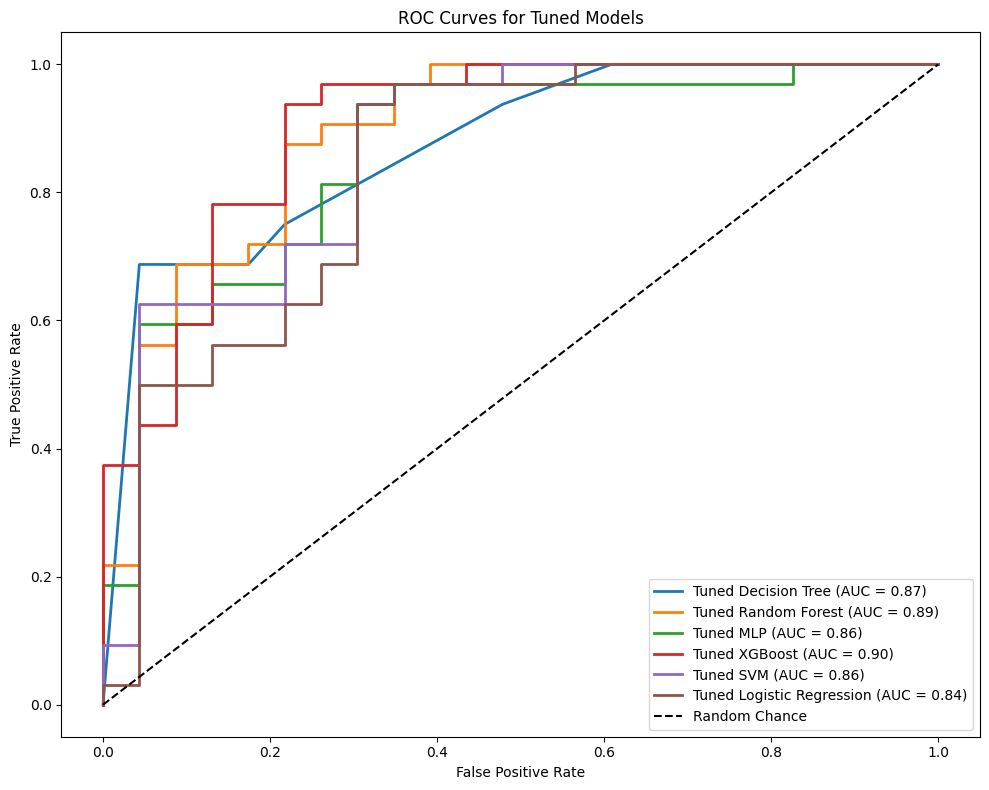

In [ ]:
plt.figure(figsize=(10, 8))

plot_model_roc(y_test, dtree_probs, "Tuned Decision Tree")
plot_model_roc(y_test, rf_probs, "Tuned Random Forest")
plot_model_roc(y_test, mlp_probs, "Tuned MLP")
plot_model_roc(y_test, xgb_probs, "Tuned XGBoost")
plot_model_roc(y_test, svm_probs, "Tuned SVM")
plot_model_roc(y_test, logreg_probs, "Tuned Logistic Regression")

# reference line
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Tuned Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5b437e7ee4e94a84c515d63c6984395acb955833c6d8d7e7cea3abdc63595b95
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_imputed,
    feature_names=X.columns,
    class_names=["No Cardio", "Cardio"],
    discretize_continuous=True,
    mode="classification"
)

i = 0
exp = explainer.explain_instance(
    X_test_imputed[i],
    xgb_best.predict_proba,
    num_features=13
)

exp.show_in_notebook(show_table=True)


In [ ]:
%pip install shap

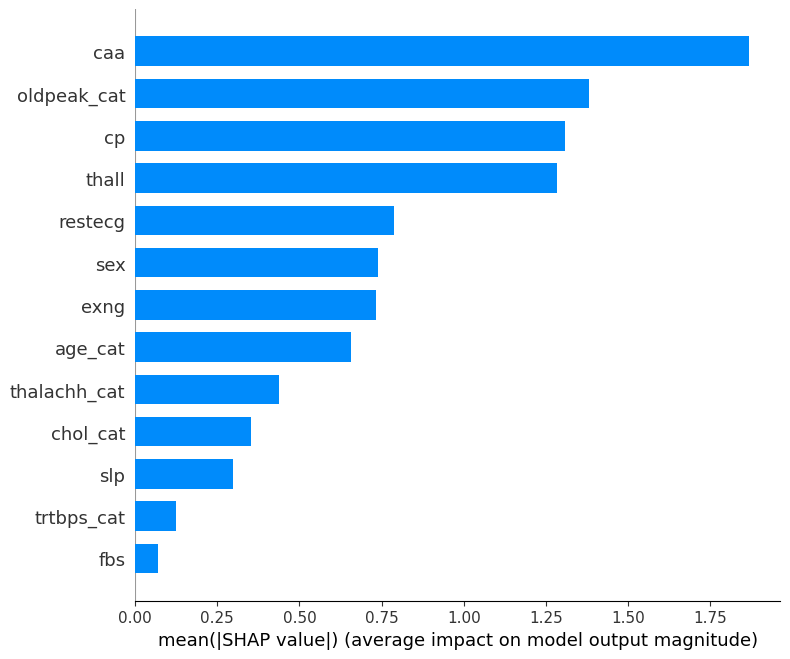

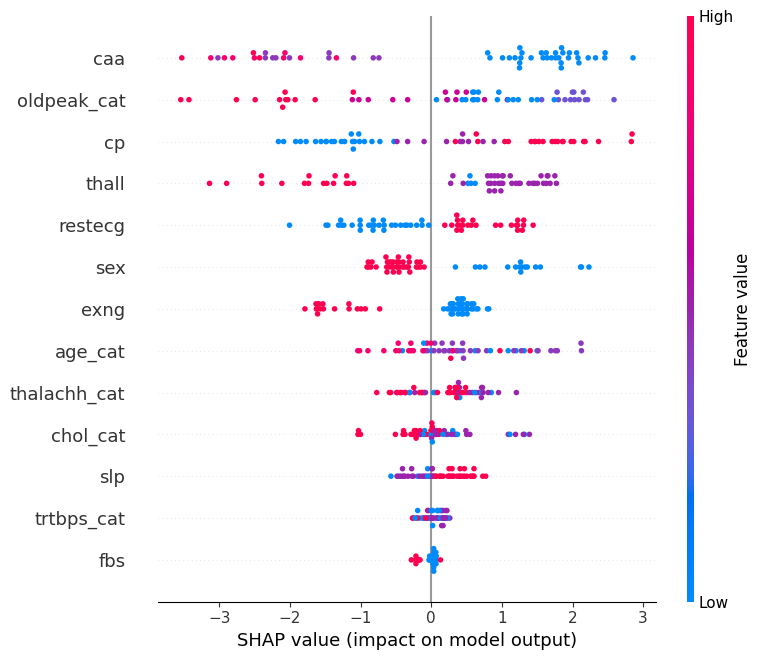

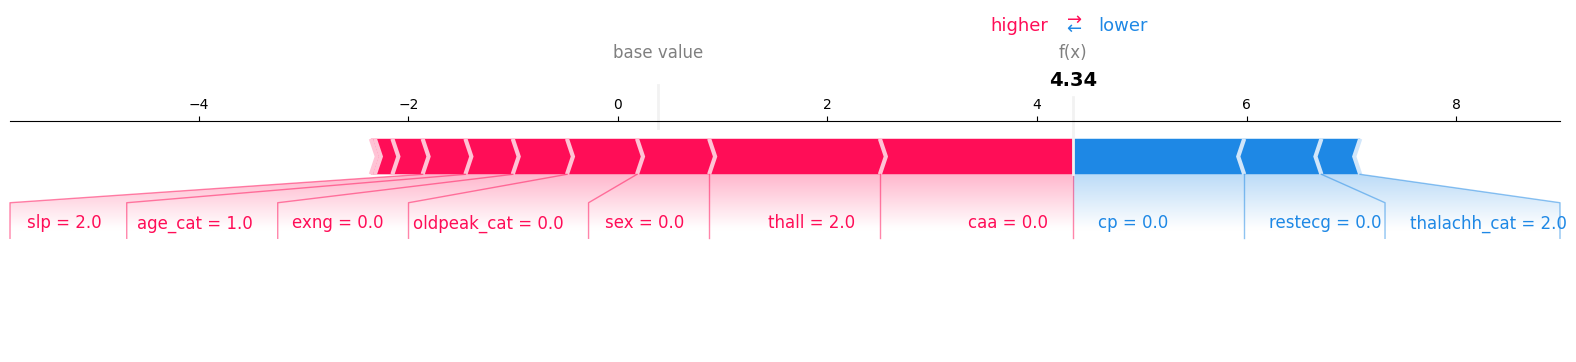

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test_imputed)
shap.summary_plot(
    shap_values,
    X_test_imputed,
    feature_names=X.columns,
    plot_type="bar",
    show=True
)

shap.summary_plot(
    shap_values,
    X_test_imputed,
    feature_names=X.columns,
    show=True
)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test_imputed[i],
    feature_names=X.columns,
    matplotlib=True
)

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.85      0.82      0.84        34

    accuracy                           0.80        55
   macro avg       0.79      0.79      0.79        55
weighted avg       0.80      0.80      0.80        55



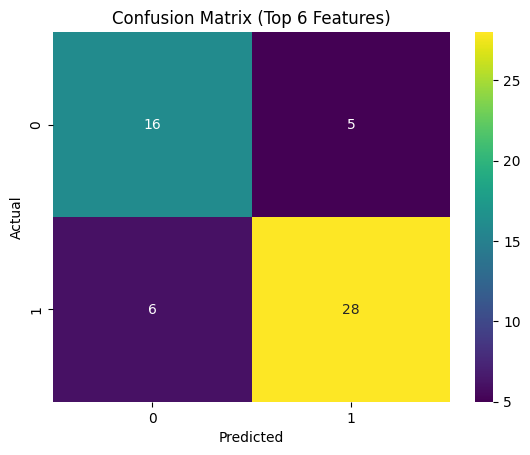

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

top_features = ['caa', 'thall', 'cp', 'oldpeak_cat', 'exng', 'thalachh_cat']
df_selected = df_no_outliers[top_features + ['output']]

X = df_selected.drop('output', axis=1)
y = df_selected['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = OrdinalEncoder()
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

# Train XGBoost model
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_enc, y_train)

# predictions
y_pred = xgb.predict(X_test_enc)

# Evaluate model
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Top 6 Features)")
plt.show()